# Predict tags on StackOverflow with linear models

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [7]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [8]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [9]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [10]:
import re
from nltk.tokenize import word_tokenize
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
j = 'BOBBY@FIRMINO c# c++ '
j.lower()
re.sub(REPLACE_BY_SPACE_RE," ",j)

'BOBBY FIRMINO c# c++ '

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +#_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):

    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE," ",text)
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = [i for i in text.split() if i not in STOPWORDS]
    return " ".join(text)

In [12]:
text_prepare(j)

'bobby firmino c# c++'

In [17]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [18]:
import itertools
import nltk
tags_counts = {}
y_train_list=list(itertools.chain.from_iterable(y_train.tolist()))
words_counts = {}
def most_common(X):
    X_train_join = " ".join(X)
    X_train_tokens = X_train_join.split()
    dist = nltk.FreqDist(X_train_tokens)
    return dist.most_common(5000)
jj= most_common(X_train)
words_counts = dict(most_common(X_train))
tags_counts = dict(most_common(y_train_list))

In [19]:
# #sorted(tags_counts.keys())
# 'c #' in words_counts
# X_train_join = " ".join(y_train_list)
# X_train_tokens = nltk.word_tokenize(X_train_join)
# dist = nltk.FreqDist(X_train_join)
# #dist.most_common(5000)
# X_train_tokens
words_counts

{'preg_replace': 44,
 'typing': 19,
 'requesting': 9,
 'cyrillic': 8,
 'highlighting': 41,
 'expect': 11,
 'npm': 21,
 'transactionscope': 9,
 'arrows': 12,
 'timestamps': 14,
 'names': 258,
 'cascade': 10,
 'asynchronously': 38,
 'grouping': 44,
 'angular': 387,
 'reactnative': 11,
 'click': 837,
 'intent': 24,
 'speed': 95,
 'wifi': 16,
 'fully': 22,
 'yet': 23,
 'relational': 11,
 'container': 128,
 'lambda': 183,
 'storage': 86,
 'end': 236,
 'swagger': 11,
 'feel': 8,
 'note': 8,
 'submits': 10,
 'choices': 21,
 'technology': 8,
 'taking': 52,
 'b': 63,
 'argumenterror': 13,
 'absolute': 66,
 'standards': 8,
 'simultaneous': 13,
 'contact': 43,
 'aspectj': 9,
 'complains': 8,
 'requestbody': 8,
 'minute': 21,
 'clients': 52,
 'average': 64,
 'cmd': 30,
 'scrolls': 9,
 'converting': 424,
 'mssql': 34,
 'nameerror': 36,
 'slug': 10,
 'reliable': 16,
 'ones': 15,
 'heroku': 155,
 'ngclick': 20,
 'freed': 12,
 'minutes': 72,
 'distribution': 26,
 'mamp': 14,
 'arg': 9,
 'reverse': 79,

In [ ]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

In [21]:
most_common_tags

[('javascript', 19078), ('c#', 19077), ('java', 18661)]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
a=list(words_counts.keys())
DICT_SIZE = 5000
WORDS_TO_INDEX = {k: v for v, k in enumerate(a)}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):

    #result_vector = np.zeros(dict_size)
    text = [text]
    vectorizer = CountVectorizer(vocabulary = words_to_index,max_features = dict_size)
    vector = vectorizer.transform(text)
    result_vector=vector.toarray()
    return result_vector



In [25]:
from scipy import sparse as sp_sparse

In [26]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [ ]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
def tfidf_features(X_train, X_val, X_test):

    tfidf_vectorizer = TfidfVectorizer(min_df=5,max_df = 0.9,ngram_range=(1, 2),token_pattern = '(\S+)')
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [31]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [32]:
'c++' in tfidf_vocab

True

In [33]:
'c#' in tfidf_vocab

True

### MultiLabel classifier

In [34]:
from sklearn.preprocessing import MultiLabelBinarizer

In [35]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [36]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [37]:
def train_classifier(X_train, y_train):

    model = OneVsRestClassifier(LogisticRegression(penalty='l1', C = 1)).fit(X_train, y_train)
    return model

In [38]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [55]:
sorted_coef_index = classifier_tfidf.coef_[0].argsort()
sorted_coef_index.shape

(18300,)

In [39]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [41]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	ruby


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic adding deleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediate advanced tutorials
True labels:	hibernate,java
Predi

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [50]:
def print_evaluation_scores(y_val, predicted):
    x = accuracy_score(y_val, predicted)
    y_macro = f1_score(y_val, predicted,average='macro')
    y_micro = f1_score(y_val, predicted,average='micro')
    y_weighted = f1_score(y_val, predicted,average='weighted')
    z_macro = average_precision_score(y_val, predicted,average='macro')
    z_micro = average_precision_score(y_val, predicted,average='micro')
    z_weighted = average_precision_score(y_val, predicted,average='weighted')
    return print(x,y_macro,y_micro,y_weighted,z_macro,z_micro,z_weighted)

In [51]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.335 0.5064073333555453 0.6544889963321107 0.6312843652137405 0.5579861088751529 0.6920932682193757 0.6814222060991837
Tfidf
0.36546666666666666 0.5087398860854617 0.6751240461993913 0.6524711523670316 0.5659063869365462 0.7137582672077514 0.7031109753152067


In [45]:
from metrics import roc_auc
%matplotlib inline

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


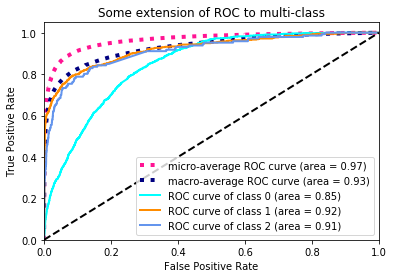

In [46]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

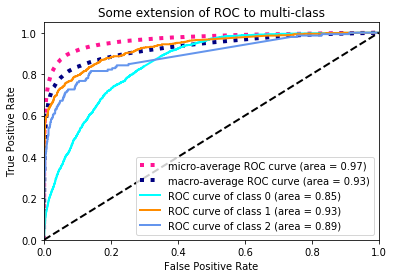

In [47]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)